In [1]:
# Import python modules
import os,sys,ogr, osr,glob
import datetime
import subprocess as sp
import tempfile
from gdalconst import *
from osgeo import gdal
import pandas as pd
import numpy as np

#os.chdir('C:/folder_name_I_FFMC/data')  
os.chdir('C:/folder_name_prj_2020/notebooks')

import pandas as pd
import gdal
import numpy as np
import time,os, glob
%matplotlib inline
import matplotlib.pylab as plt

import matplotlib.patches as patches #needed for drawing rectangles
from skimage import exposure #enhance image display
gdal.UseExceptions()

In [2]:
# Set DryRun to True for a list of the gdalbuildvrt commands only without making the call
DryRun=False
# Give the root directory where the subdirectories containing the RTC files are stored
#rootdir='C:/folder_name_tHome/NDWI_FFMC/data'
rootdir='C:/folder_name_/prj_2020'

#rootdir=r'folder_name_RS_Task_Workspaces/Modis_NDWI_pilot')
# Give list of RTC directories relative to the rootdir
#rtcdirs=['S32631X398020Y1315440sS1_A_vh_mtfil','S32631X398020Y1315440sS1_A_vv_mtfil']
rtcdirs=['NDWI']
# Give a target extent in projection coordinates
targetextent=None
# Give targetextent as "xmin ymin xmax ymax"
# targetextent="398020.000 1315440.000 482880.000 1390960.000 "
#targetextent="378100.000 6494600.000 431200.000 6405500.000 "

In [3]:
def make_timeseries_vrt(rootdir,subdir,targetextent=None,prefix='',DryRun=False):
    '''
    Make a vrt stack from time series data stored in a subdirectory 

    Author: Josef Kellndorfer (2018)

    INPUT:
    rootdir        Path to the root directory where the subdirectory is stored
    subdir         Name of the subdirectory containing the time series data as geotiffs (.tif ending)
    targetextent   None or string as "xmin ymin xmax ymax" in projection units
    prefix         Optional prefix for the vrt filename. Default is subdirectory name with .vrt ending
    DryRun         prints only the gdalbuild command with out executing it

    OUPUT:
    - vrt stacks for each RTC directory, for each path, and for the combined stacks. ENDING: .vrt
    - corresponding date files with "YYYYMMDD" entries per line per date. ENDING: .dates

    Will generate .vrt time series stacks with bands named by dates. 

    Some assumptions:

    1) This notebook assumes that all the data to be stacked are pre-processed into the same projection, 
    pixel-spacing, and corner coordinates are fraction-less multiples of the pixel-spacing. 
    In other words, when overlaying the data they can be offset, but need to be offset by 
    full multiples of the pixel spacing. If this is not that case, the data sets need 
    to be pre-processed e.g. with gdalwarp for correct stacking. 
    For example, SAR data of the same poliarization mode and flightdirection 
    should be grouped in one subdirectory. 

    2) Naming conventions: The filenames contain information on the data takes, including date and path, 
    separated by an underscore e.g.:

      prefix_YYYYMMDD_PPPP_postfix.tif  where Y=year, M=month, D=day, P=path 

      NOTE: Only one "_YYYYMMDD_"  can be part of the filename including directory path name. 
            Also, the "_PPPP_" part needs to be unique in the filename

    3) If data with different corner locations are stacked, the VRT extent will be the maximum extent
    of all files stacked. A subset extent can be specified however with the targetextent parameter.
    '''

    # Get current vorking directory and change to the root directory
    cwd=os.getcwd()
    os.chdir(rootdir)
    print(cwd)
    #*******************************
    imagelist = [x for x in glob.glob(os.path.join(subdir,'*.tif'))]
    # Get index for a valid date in the '_' separated list
    first=imagelist[0].split('_')
    print("first",first)
    print(len(first))
    for i in range(len(first)):
        try:
            datetime.datetime.strptime(first[i],'%Y%m%d')
            idx=i  
            print("idx:",idx)
        except ValueError:
            next
    # Now get the dates for all the files
    dates=[x.split('_')[idx] for x in imagelist]
    # Sort by dates and resort the imagelist accordingly
  #  print("dates:",dates)
    datessorted=dates.copy()
    datessorted.sort()
    print("datessort:",datessorted)
    indices=[dates.index(x) for x in datessorted]
    
    imagelistsorted=[imagelist[x] for x in indices]
    
    #*********************************
#     in_directory = r'C:/_LOCALdata/bobo/TimeSeries/ts_example/CAD_ndvi'
#     files_to_process = glob.glob(os.path.join(in_directory, '*.tif'))
#     imagelist = [x for x in glob.glob(os.path.join(subdir,'*.tif'))]
#     # Get index for a valid date in the '_' separated list
    
    # Get all the distict paths
    paths=[x.split('_')[idx+1] for x in imagelistsorted]
    print("path:",paths)
    distinct_paths=set(paths)

    # We make a directory with vrtnames and have filelists as the entry
    vrtnames={}

    # Make a vrtname for the entire stack. We use the subdir name as the root for the vrt file:
    vrtname=prefix+subdir+'.vrt'
    #print("vrtname:",vrtname)
    vrtnames[vrtname]={'filenames':imagelist, 'dates':dates}
    #print("vrtnames",vrtnames)
    # Now make vrtnames and corresponding lists for files and dates by path:
    for p in distinct_paths:
        #print("p",p)
        # Get the subset of the imagelist that corresponds to this path:
        imagelist_subset=[x for x in imagelistsorted if x.find('_'+p+'_')>-1]
        #print("imagelist_subset:",imagelist_subset)
        dates_subset=[x.split('_')[idx] for x in imagelist_subset]
        #print("dates_subset:",dates_subset)
        # VRT name is constructed from the first filename in the rtc list without the 
        vrtname=prefix+subdir+'_'+p+'.vrt'
        #print("vrtname:", vrtname)
        
        vrtnames[vrtname]={'filenames':imagelist_subset, 'dates':dates_subset}
        #print("?",vrtnames[vrtname])

    # Now build the vrts:
    if targetextent==None:
        te=''
    else:
        te='-te '+ targetextent

    for i in vrtnames:
        tfile=tempfile.NamedTemporaryFile(mode='w+',delete=False)
        for j in vrtnames[i]['filenames']:
            tfile.write(j+'\n')
        tfile.close()
        cmd='gdalbuildvrt -separate -allow_projection_difference {} -input_file_list {} -overwrite {}'.format(te,tfile.name,i)
        if not DryRun:
            sp.call(cmd.split())
            # Write the dates files
            datefilename=i.replace('.vrt','.dates')
            with open(datefilename,"w+") as f:
                for j in vrtnames[i]['dates']:
                    f.write(j+'\n')
            # Set the band names as dates
            img_handle=gdal.Open(i)
            for j in range(img_handle.RasterCount):
                x=vrtnames[i]['dates'][j]
                # Reformat YYYYMMDD to YYYY-MM-DD
                date=x[:4]+'-'+x[4:6]+'-'+x[6:8]
                # Set the Metadata and Description to the date
                band=img_handle.GetRasterBand(j+1)
                band.SetMetadataItem("Date",date)
                band.SetDescription(date)
            del img_handle
        else:
            print('DryRun:',end=' ')
        print(cmd)

        os.remove(tfile.name)
    # Switch back to the original working directory
    os.chdir(cwd)

In [4]:
# subdir = 'subdir = 'C:/folder_name_20/NDWI'

# make_timeseries_vrt(rootdir,subdir,targetextent=None,prefix='',DryRun=False)'


In [5]:
datadirectory=rootdir
os.chdir(datadirectory)
datefile='NDWI.dates'
imagefile='NDWI.vrt'
os.getcwd() 

'C:\\_LOCALdata\\prj_2020'

In [6]:
#create datetime index, first read Dates file and then convert it with DatetimeIndex
dates=open(datefile).readlines()
#print(dates)
tindex=pd.DatetimeIndex(dates)
tindex

# # From the index we make and print a lookup table for 
# # band numbers and dates 
j=1
print('Bands and dates for',imagefile)
for i in tindex:
    #'j' refers to band , while 'i.date()' excludes time
    
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    #print into 5 columns.....
    if j%5==1: 
        print()

Bands and dates for NDWI.vrt
   1 2019-01-01    2 2019-01-09    3 2019-01-17    4 2019-01-25    5 2019-02-02 
   6 2019-02-10    7 2019-02-18    8 2019-02-26    9 2019-03-06   10 2019-03-14 
  11 2019-03-22   12 2019-03-30   13 2019-04-07   14 2019-04-15   15 2019-04-23 
  16 2019-05-01   17 2019-05-09   18 2019-05-17   19 2019-05-25   20 2019-06-02 
  21 2019-06-10   22 2019-06-18   23 2019-06-26   24 2019-07-04   25 2019-07-12 
  26 2019-07-20   27 2019-07-28   28 2019-08-05   29 2019-08-13   30 2019-08-21 
  31 2019-08-29   32 2019-09-06   33 2019-09-14   34 2019-09-22   35 2019-09-30 
  36 2019-10-08   37 2019-10-16   38 2019-10-24   39 2019-11-01   40 2019-11-09 
  41 2019-11-17   42 2019-11-25   43 2019-12-03   44 2019-12-11   45 2019-12-19 
  46 2019-12-27 

### Image data
#### Get the time series raster stack from the entire training data set.


In [7]:

#### Plot the global means of the Time Series
# 1. Conversion to poZer
# 2. Compute means
# 3. Convert to dB
# 4. Make a pandas time series
# 5 Plot time series of means
# metrics=timeseries_metrics(rasterPwr.filled(np.nan),ndv=np.nan)

In [8]:
#choose one band
band_num = 30

#read entire image into an 3D stack
rasterstack=gdal.Open(imagefile).ReadAsArray()

rasterstack.shape

(46, 301, 222)

In [9]:
# for each band create a mean
#  Compute Means

rs_means = np.mean(rasterstack,axis=(1,2))

In [10]:
# 1. Conversion to Power
#caldB=-83
#calPwr = np.power(10.,caldB/10.)
#rasterstack_pwr = np.power(rasterstack,2.)*calPwr
# 2. Compute Means
# 3. Convert to dB
#rs_means_dB = 10.*np.log10(rs_means_pwr)

### Make a pandas time series object

In [11]:
#we create a Series with Dates as index and a column of individual band means

ts_ndwis = pd.Series(rs_means,index=tindex)
ts_ndwis.head()


2019-01-01    2068.132860
2019-01-09    1400.865149
2019-01-17    1744.547065
2019-01-25    1850.404418
2019-02-02    1591.246880
dtype: float64

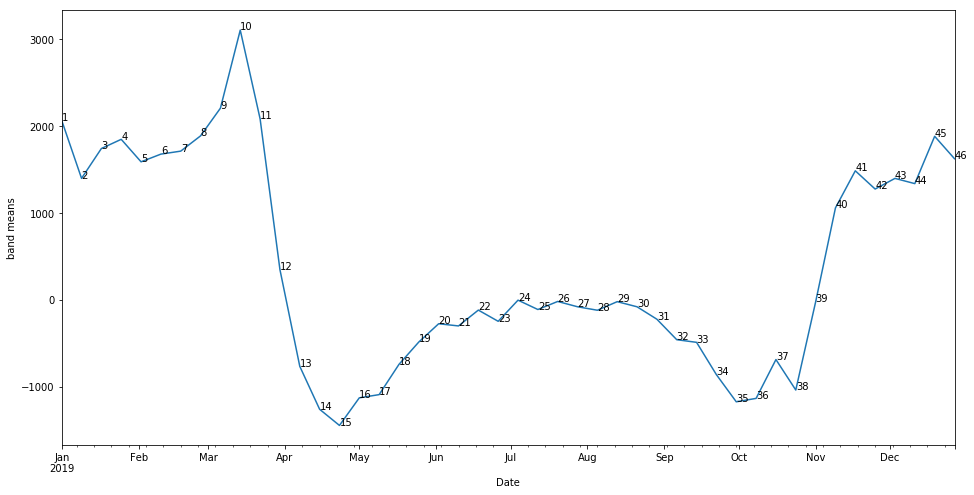

In [12]:
#  Use the pandas plot function of the time series object to plot
# Put band numbers as data point labels
plt.figure(figsize=(16,8))
ts_ndwis.plot()
xl = plt.xlabel('Date')
yl = plt.ylabel('band means')
for xyb in zip(ts_ndwis.index, rs_means,range(1,len(ts_ndwis)+1)):
    plt.annotate(xyb[2],xy=xyb[0:2])


For example to pick one pixel at a line/pixel location and obtain all band values, use:

**[ : , line , pixel]** notation.

Or, if we are interested in a subset at an offset location we can use:

**[ : , yoffset : (yoffset + yrange), xoffset : (xoffset + xrange)]**

below we will generate TS plots for point locations (pixels) or areas (e.g. a 5x5 window region). 
To show individual bands, we define a **showImage()** function which incorporates the matrix slicing from above.

In [13]:
def showImage(rasterstack,tindex,bandnbr,subset=None,vmin=None,vmax=None):
    '''Input: 
    rasterstack stack of images in ndwi units     tindex time series date index
    bandnbr--> bandnumber of the rasterstack to dissplay'''
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # If vmin or vmax are None we use percentiles as limits:
    if vmin==None: vmin=np.percentile(rasterstack[bandnbr-1].flatten(),5)
    if vmax==None: vmax=np.percentile(rasterstack[bandnbr-1].flatten(),95)

    ax1.imshow(rasterstack[bandnbr-1],cmap='gray',vmin=vmin,vmax=vmax)
    ax1.set_title('Image Band {} {}'.format(bandnbr,tindex[bandnbr-1].date()))
    if subset== None:
        bands,ydim,xdim=rasterstack.shape
        subset=(0,0,xdim,ydim)  #entire size or the image
        
    ax1.add_patch(patches.Rectangle((subset[0],subset[1]),subset[2],subset[3],fill=False,edgecolor='red'))
    ax1.xaxis.set_label_text('Pixel')
    ax1.yaxis.set_label_text('Line')
    
    ts_ndwi=np.mean(rasterstack[:,subset[1]:(subset[1]+subset[3]),subset[0]:(subset[0]+subset[2])],axis=(1,2))
    #mean value for the subset area
    
 
    ax2.plot(tindex,ts_ndwi)
    ax2.yaxis.set_label_text('ndwi units')
    ax2.set_title('ndwi Time Series')
    # Add a vertical line for the date where the image is displayed
    ax2.axvline(tindex[bandnbr-1],color='red')

    fig.autofmt_xdate()

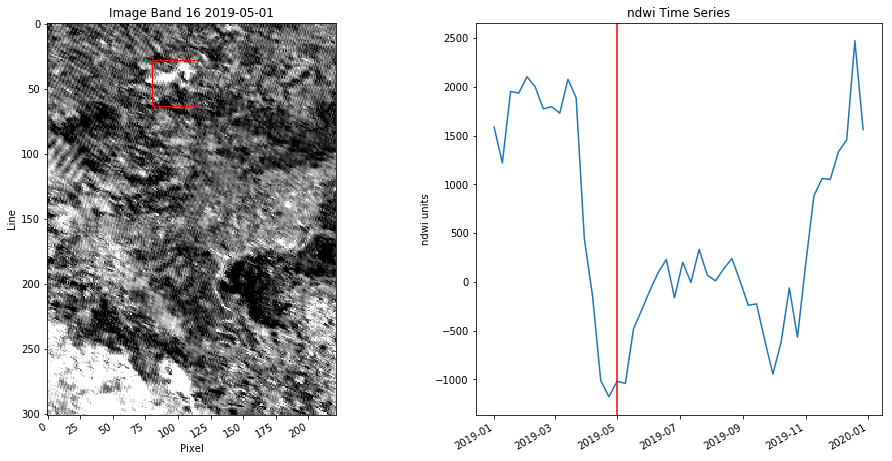

In [14]:
bandnbr_June =21  # beginig of June
bandnbr_May = 16
#subset = (98,51,2,2)  position of NE weather station (RLA) and area 1km square around
#WT station in deciduous stands
WT_dec_sub=(98,51,1,1)
WT_con_sub=(95,43,10,10)
con_sub=(80,28,35,35)
#plot of conifers in May
showImage(rasterstack,tindex,bandnbr_May,con_sub)



### TIME SERIES VISUALIZATION AND ANIMATIONS¶
#### Prepare the Animations

### Helper function to create TS object


In [15]:
# Imports
import os
import time
import gdal
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Needed to draw rectangles
from matplotlib import animation, rc
from IPython.display import HTML

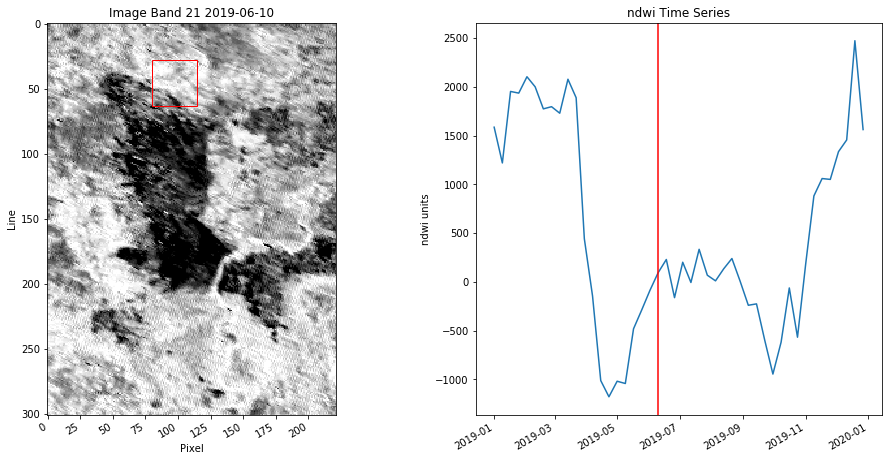

In [18]:
# Plot one band and subset outline to see which subset we are interested in
#we may read as Array entire image with all bands at once
#raster=img.ReadAsArray(*subset)  #whole image
#raster=band.ReadAsArray(*subset)
# raster_an=band.ReadAsArray()
rasterstack[16].shape
# vmin=np.percentile(rasterstack[16].flatten(),5)
# vmax=np.percentile(rasterstack[16].flatten(),95)

# fig=plt.figure(figsize=(10,10))
# ax=fig.add_subplot(111)

# #plot of deciduous in June
# #showImage(rasterstack,tindex,bandnbr_June,WT_dec_sub)
#ax.imshow(rasterstack[16],cmap='gray',vmin=vmin,vmax=vmax)
# # plot the subset as rectangle
# #plot of deciduous in June
showImage(rasterstack,tindex,bandnbr_June,con_sub)
_=ax.add_patch(patches.Rectangle((con_sub[0],con_sub[1]),con_sub[2],con_sub[3], fill=False,edgecolor='red'))

In [19]:
# Open the image and read the first raster band
img = gdal.Open(imagefile)
band = img.GetRasterBand(1)
# Set the subset
if con_sub==None:
    con_sub=(0,0,img.RasterXSize,img.RasterYSize)

In [20]:
raster0 = band.ReadAsArray(*con_sub)

bandnbr=0 # Needed for updates
rasterstack4a=img.ReadAsArray(*con_sub)
print("r0:",raster0.shape )
rasterstack4a.shape

r0: (35, 35)


(46, 35, 35)

In [21]:
%%capture 
#import matplotlib.pyplot as plt
import matplotlib.animation
# import numpy as np

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.axis('off')
vmin=np.percentile(rasterstack4a.flatten(),5)
vmax=np.percentile(rasterstack4a.flatten(),95)

im = ax.imshow(raster0,cmap='gray',vmin=vmin,vmax=vmax)
ax.set_title("{}".format(tindex[0].date()))

def animate(i):
    ax.set_title("{}".format(tindex[i].date()))
    im.set_data(rasterstack4a[i])

# # Interval is given in milliseconds
ani = matplotlib.animation.FuncAnimation(fig, animate,frames=rasterstack4a.shape[0], interval=400)

In [22]:
rc('animation',embed_limit=40971520.0)  # We need to increase the 
            # limit maybe to show the entire animation

In [23]:
from IPython.display import HTML
HTML(ani.to_jshtml())

# A two part figure with moving global mean backscatter of the time series 

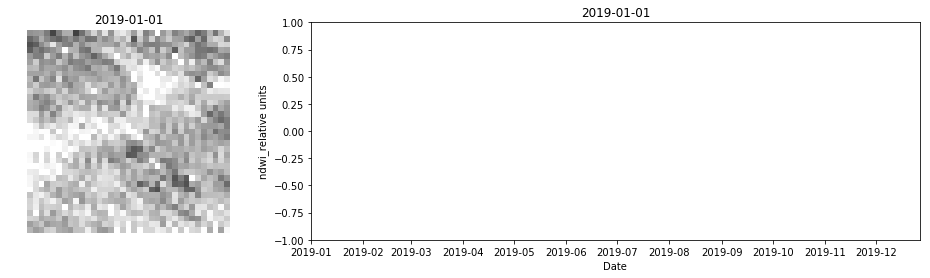

In [24]:

# ts_ndwis 

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4),gridspec_kw = {'width_ratios':[1, 3]})

vmin=np.percentile(rasterstack4a.flatten(),5)
vmax=np.percentile(rasterstack4a.flatten(),95)
im = ax1.imshow(raster0,cmap='gray',vmin=vmin,vmax=vmax)
ax1.set_title("{}".format(tindex[0].date()))
ax1.set_axis_off()

ax2.axis([tindex[0],tindex[-1],ts_ndwis.min(),ts_ndwis.max()])
ax2.set_ylabel('ndwi_relative units')
ax2.set_xlabel('Date')
ax2.set_ylim((-1,1))
l, = ax2.plot([],[])


def animate(i):
    ax1.set_title("{}".format(tindex[i].date()))
    im.set_data(rasterstack4a[i])
    ax2.set_title("{}".format(tindex[i].date()))
    l.set_data(tindex[:(i+1)],ts_ndwis[:(i+1)])

# Interval is given in milliseconds
ani = matplotlib.animation.FuncAnimation(fig, animate,frames=rasterstack4a.shape[0], interval=400)

In [25]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [26]:
# a =pd.Series(rs_means_ndvi,index=tindex)

In [27]:

# s = pd.Series([1.1, 2.0, np.nan, 4.0])
# s.astype('Int32')

def timeSeries(rasterstack,tindex,subset,ndv=0.):
    # Extract the means along the time series axes
    # raster shape is time steps, lines, pixels. 
    # With axis=1,2, we average lines and pixels for each time 
    # step (axis 0)
    raster=rasterstack.copy()
    if ndv != np.nan: 
        raster[np.isnan(raster)]= np.nanmean(raster)
        #raster[np.equal(raster,ndv)]=np.nan
        
        
    ts_ndwi=np.nanmean(raster[:,subset[1]:(subset[1]+subset[3]),
                       subset[0]:(subset[0]+subset[2])],axis=(1,2))
    
    # make the pandas time series object
    ts = pd.Series(ts_ndwi,index=tindex)
    # return it
    return ts

In [28]:
raster=rasterstack.copy()
# raster
ndv=0.0
# if ndv != np.nan: 
#     #raster[np.isnan(raster)]= np.nanmean(raster)
#     r = raster[np.isnan(raster)]
r =np.isnan(raster)
#raster[r]
#raster[np.equal(raster,ndv)]=np.nan
#np.equal(raster,ndv)
raster[np.equal(raster,ndv)]

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [29]:
ts = timeSeries(rasterstack,tindex,WT_dec_sub)

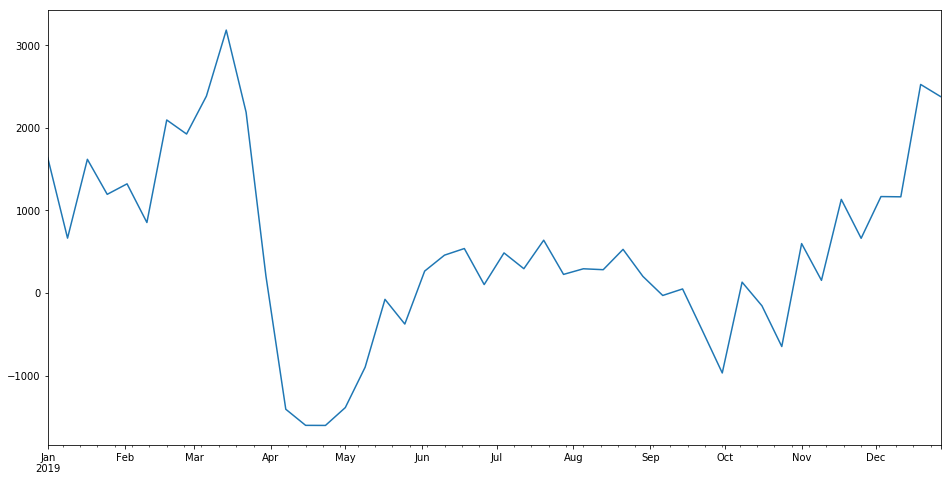

In [30]:
_=ts.plot(figsize=(16,8))  # _= is a trick to suppress more output.


### Seasonal Subsets of Modis NDWI time series 

##### Often it is desirable to subset time series by season or months to compare with similar conditions of a previous year's observation.  We will make use of the pandas datatime index tools:

**month**
**day of year**
##### First we extract the time series again for a area at the subset location (WT ws). We then convert the pandas time series to a pandas DataFrame to allow for more processing options. We also label the data value column 

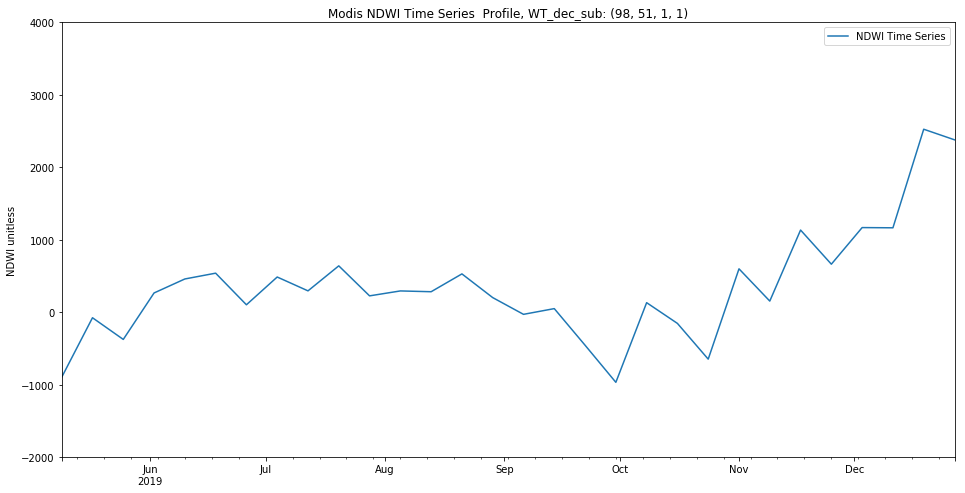

In [31]:
#subset1=(70,33,2,2)
#WT ws in deciduous stands
ts = timeSeries(rasterstack,tindex,WT_dec_sub)
ts2df = pd.DataFrame(ts,index=ts.index,columns=['ndwis'])
ts2df_sub1=ts2df[ts2df.index >'2019-05-01']

# Plot
ylim=(-2000,4000)
ts2df_sub1.plot(figsize=(16,8))
#ts2df.plot(figsize=(16,8))
plt.title('Modis NDWI Time Series  Profile, WT_dec_sub: {}'.format(WT_dec_sub))
plt.ylabel('NDWI unitless')
plt.ylim(ylim)
_=plt.legend(["NDWI Time Series"])



## Subset by months:
#### We can make use of pandas DateTimeIndex object index.month and numpy's logical_and function to subset a time series easily by month.

#### May to Octobar data only

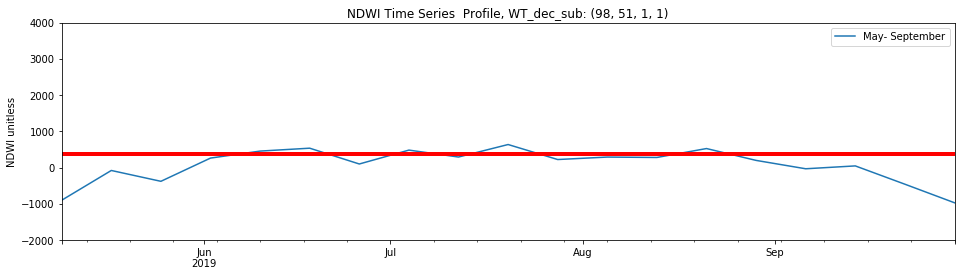

In [32]:
ts2df_sub2=ts2df_sub1[np.logical_and(ts2df_sub1.index.month >=5,ts2df_sub1.index.month<=9)]

# Plot
fig, ax = plt.subplots(figsize=(16,4))
ts2df_sub2.plot(ax=ax)
plt.title('NDWI Time Series  Profile, WT_dec_sub: {}' .format(WT_dec_sub))
plt.ylabel('NDWI unitless')
plt.ylim(ylim)
plt.axhline(np.mean(rasterstack),linewidth=4, color='r')
_=plt.legend(["May- September"])

In [33]:
np.mean(rasterstack)

378.8332061297178

## All other months
#### Using numpy's boolean invert function, we can invert a selection and in this example get to all other months:

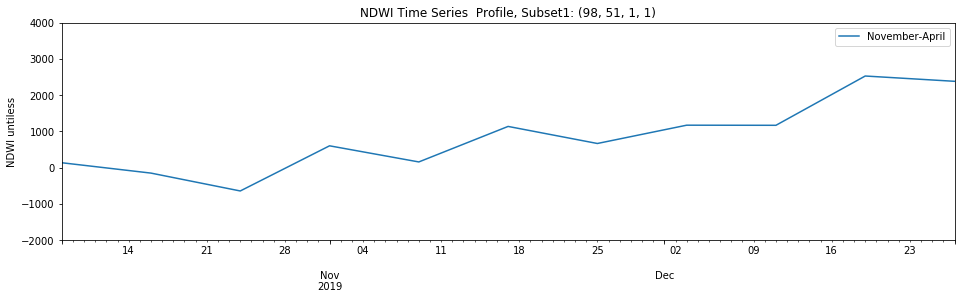

In [34]:
ts2df_sub2inv=ts2df_sub1[np.invert(np.logical_and(ts2df_sub1.index.month>=5,ts2df_sub1.index.month<=9))]

# Plot
fig, ax = plt.subplots(figsize=(16,4))
ts2df_sub2inv.plot(ax=ax)
plt.title('NDWI Time Series  Profile, Subset1: {}'.format(WT_dec_sub))
plt.ylabel('NDWI untiless')
plt.ylim(ylim)
_=plt.legend(["November-April"])

## Group time series by Month to compare average NDWI values

In [35]:
ts_sub_by_month = ts2df_sub1.groupby(pd.Grouper(freq="M"))
ts_sub_by_month

(-2000, 4000)

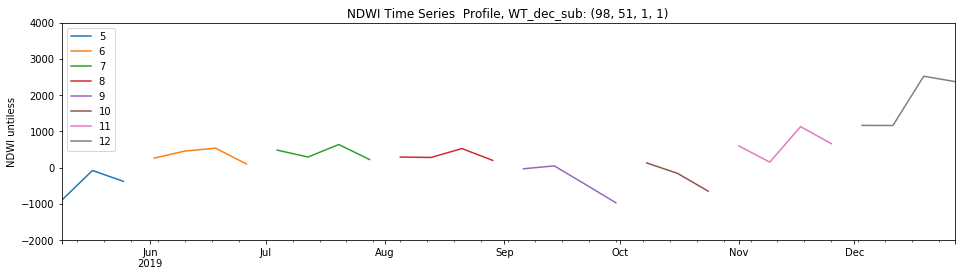

In [36]:
fig, ax = plt.subplots(figsize=(16,4))
for label, df in ts_sub_by_month:
   # df.g0.plot(ax=ax, label=label.year)
    df.ndwis.plot(ax=ax, label=label.month)
    
plt.legend()
# ts_sub_by_year.plot(ax=ax)
plt.title('NDWI Time Series  Profile, WT_dec_sub: {}'.format(WT_dec_sub))
plt.ylabel('NDWI untiless')
plt.ylim(ylim)


In [39]:
import numpy as np
import matplotlib.pyplot as plt
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 20,10
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

#eread file   , index_col=0, format='%Y-%m-%d')
#weather_df = pd.read_csv(r"C:/folder_name_MC/data/weather_5ws.txt", sep=",")
weather_df = pd.read_csv(r"C:folder_name_ther_5ws.txt", sep=",")
#print
weather_df.head(1)

,Unnamed: 0,DATE,STATN_ID,LAT,LONG,TEMP,R_H,W_S_kmh,PRECIP,FFMC,datum,year
0,2,2017-05-07 12:00:00,BC,58.195219,-118.218453,7.0,68.96,26,0.0,84.0,2017-05-07 12:00:00,2017


In [41]:
#Set up weather date as a time index
weather_df['DATE'] = pd.to_datetime(weather_df.DATE, format='%Y-%m-%d')
weather_df.index = weather_df['DATE']
weather_df.head(1)

,Unnamed: 0,DATE,STATN_ID,LAT,LONG,TEMP,R_H,W_S_kmh,PRECIP,FFMC,datum,year
DATE,,,,,,,,,,,,
2017-05-07 12:00:00,2,2017-05-07 12:00:00,BC,58.195219,-118.218453,7.0,68.96,26,0.0,84.0,2017-05-07 12:00:00,2017


In [42]:
# #set index as date
# weather_df['DATE'] = pd.to_datetime(weather_df.WEATHER_DATE, format='%Y-%m-%d')
# weather_df.index = weather_df['DATE']
# #eather_df.head()

#Check if 'DATE' index is Time variable 
weather_df1 = weather_df.copy()
weather_df1.DATE.dtype

dtype('<M8[ns]')

In [43]:
import datetime
#weather_df1['year'] = weather_df1.WEATHER_DATE.dt.year
weather_df1['day'] = weather_df1.DATE.dt.day
weather_df1['month'] = weather_df1.DATE.dt.month
weather_df1.head(1)

,Unnamed: 0,DATE,STATN_ID,LAT,LONG,TEMP,R_H,W_S_kmh,PRECIP,FFMC,datum,year,day,month
DATE,,,,,,,,,,,,,,
2017-05-07 12:00:00,2,2017-05-07 12:00:00,BC,58.195219,-118.218453,7.0,68.96,26,0.0,84.0,2017-05-07 12:00:00,2017,7,5


In [205]:
#(df['A'] < 5) & (df['B'] > 5)
s_2019_BC = weather_df1.loc[(weather_df1.year == 2019) & (weather_df1.STATN_ID == 'BC') ,['FFMC','PRECIP','TEMP','W_S_kmh','R_H']]
# #summer_2019_BC.tail()
s_2019_WT = weather_df1.loc[(weather_df1.year == 2019) & (weather_df1.STATN_ID == 'WT') ,['FFMC','PRECIP','TEMP','W_S_kmh','R_H']]
# # summer_2019.shape  #it includes TGA and RLA 
s_2019_RLA = weather_df1.loc[(weather_df1.year == 2019) & (weather_df1.STATN_ID == 'RLA') ,['FFMC','PRECIP','TEMP','W_S_kmh','R_H']]
# #summer_2019_RLA = summer_2019.loc[weather_df1.STATION_ID == 'RLA'  ,['FFMC','PRECIP']]
# # #select NDWI period  for summer 2019
summer_2019_WT =s_2019_WT['2019-04-01':'2019-09-26']
summer_2019_BC =s_2019_BC.loc['2019-04-01':'2019-09-26']
summer_2019_RLA =s_2019_RLA['2019-04-01':'2019-09-26']
# # #or 
# # tsdf_summer=ts2df[np.logical_and(ts2df.index.month>=5,ts2df.index.month<=8)]
summer_2019_WT.tail(1)
# summer_2019_RLA.tail()

,FFMC,PRECIP,TEMP,W_S_kmh,R_H
DATE,,,,,
2019-09-26 12:00:00,80.0,0.0,7.0,10,57.96


In [206]:
#We need index to be a time object in TS and merging TS
summer_2019_WT.index.dtype

dtype('<M8[ns]')

In [143]:
# summer_2019_WT.head(15)

### Drill through one pixel near WT station
##### Extract the values for all timeseries and attach the Timeindex

In [64]:
# subset at coniferous stand:  conif_sub=( 100 , 45,1,1)
yoffset = 43
xoffset = 94
xrange = 1
yrange = 1
#stack[:,line,cols]
conif_sample = rasterstack[ : , yoffset : (yoffset + yrange), xoffset : (xoffset + xrange)]
#conif_sample.reshape(46,1)
#we get here a ndarray that we need into a dataframe form

# 14:
#dataset = pd.DataFrame( conif_sample[:, 0],  index=[i+1 for i in range(46)])
dataset2 = pd.DataFrame( conif_sample[:, 0], columns = ['ts_ndwi'],index=tindex) 
dataset2.head(1)

# dataset1.shape

,ts_ndwi
2019-01-01,1530


In [65]:
#Assign the name to index of dataframe
#if you consider mergening different dataframes, then skip indexing at this point
dataset2.index.name = 'DATE'

In [211]:
#dataset2.info()

In [74]:
#make a copy of df
dataset3 = dataset2.copy()

In [156]:
#To merge two df's with Date field, make sure to have dates in the same format.
#our weather df has 'Date' in "%Y-%m-%d %H:%M:%S" format

dataset3['DATUM'] = dataset3.index.strftime("%Y-%m-%d %H:%M:%S") 
#pd.to_datetime('2010/11/12', format='%Y/%m/%d')

In [157]:
dataset3.head(1)

,ts_ndwi,DATUM
DATE,,
2019-01-01,1530,2019-01-01 00:00:00


In [164]:
#dataset3.info()
#convert 'DATUM' string object to Time object
dataset3['DATUM'] =pd.to_datetime(dataset3.DATUM, format = "%Y-%m-%d %H:%M:%S")
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')

In [ ]:
#before merging to TS dataframes, the index must be removed and need to be a column
#for that reason we 'reset_index'

In [213]:

dataset3_a=dataset3.reset_index()
# dataset2.reset_index()
#dataset3_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
DATE       46 non-null datetime64[ns]
ts_ndwi    46 non-null int16
DATUM      46 non-null datetime64[ns]
dtypes: datetime64[ns](2), int16(1)
memory usage: 956.0 bytes


In [152]:
#Rename the fields to match 'DATE' column in another (weather) df
dataset3_a.rename(columns={'DATE':'DATE_' ,'DATUM':'DATE' },  inplace=True)
dataset3_a.head(1)

,DATE_,ts_ndwi,DATE
0,2019-01-01,1530,2019/01/01 00:00:00


In [116]:
dataset4['DATETIME'] = pd.to_datetime(dataset4['DATE'])
# or  datetime.strptime(date_str3, "%Y/%m/%d %H:%M:%S")
# dataset4.set_index('DATETIME')
# 

In [121]:
#dataset4= dataset4.set_index('DATETIME')
# dataset4.drop(['DATETIME'],axis=1,inplace=True)
dataset4.head(1)

,DATE_,ts_ndwi
DATETIME,,
2019-01-01,2019-01-01,1530


In [102]:
#Convert "DATE" as non null object to a datetime object
dataset4['DATE'] = pd.to_datetime(dataset4['DATE'])
#format='%d%b%Y:%H:%M:%S.%f'
dataset4.set_index = dataset4['DATE']

In [125]:
dataset4.shape
dataset4.columns
dataset5 = dataset4.copy()

In [127]:
#dataset5.info()
dataset5 = dataset5[['ts_ndwi']]
dataset5.head(1)

,ts_ndwi
DATETIME,
2019-01-01,1530


In [216]:
#delete df to save memory

#delete df's
# lst = [dataset4, dataset3 ]
# del lst 


summer_2019_WT_noInd = summer_2019_WT.reset_index()


#### Merging 2 dataframe

In [217]:
summer_2019_WT_noInd.tail()

,DATE,FFMC,PRECIP,TEMP,W_S_kmh,R_H
134,2019-09-22 12:00:00,83.4,0.0,15.0,27,54.84
135,2019-09-23 12:00:00,83.4,0.0,9.0,27,66.02
136,2019-09-24 12:00:00,83.4,0.0,8.5,6,71.25
137,2019-09-25 12:00:00,75.3,1.0,5.0,13,79.76
138,2019-09-26 12:00:00,80.0,0.0,7.0,10,57.96


In [224]:
WT_weath =summer_2019_WT_noInd.copy()


In [256]:
#THIS IS NOT GOOD BUT PRODUCES A PRODUCT.  aDD A column DATUM
WT_weath['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))
WT_weath.head()
WT_weath['DATUM'] = WT_weath['DATE'][1]
WT_weath['DATUM'].dtype

dtype('<M8[ns]')

In [258]:
#convert '2019-09-22 12:00:00' format to this '2019-09-22' format
#WT_weath['dat'] = WT_weath['DATE'].strftime('%Y-%m-%d')
#data['date'] = pd.to_datetime(data['date'], errors='coerce')
for i in range(WT_weath.shape[0]):
    s=WT_weath.DATE[i]
    #print(s)
    WT_weath['DATUM'][i] = s.strftime('%Y-%m-%d')
 

C:\Users\bob.stankovic\AppData\Local\Continuum\Anaconda3\envs\testgdal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [260]:
WT_weath.tail()

,DATE,FFMC,PRECIP,TEMP,W_S_kmh,R_H,DATUM
134,2019-09-22 12:00:00,83.4,0.0,15.0,27,54.84,2019-09-22
135,2019-09-23 12:00:00,83.4,0.0,9.0,27,66.02,2019-09-23
136,2019-09-24 12:00:00,83.4,0.0,8.5,6,71.25,2019-09-24
137,2019-09-25 12:00:00,75.3,1.0,5.0,13,79.76,2019-09-25
138,2019-09-26 12:00:00,80.0,0.0,7.0,10,57.96,2019-09-26


In [261]:
#Drop the column we do not need , make sure to use 'axis = 1'
WT_weath_no_Ind = WT_weath.drop(['DATE'],axis = 1)


In [262]:
WT_weath_no_Ind.head(1)

,FFMC,PRECIP,TEMP,W_S_kmh,R_H,DATUM
0,84.8,0.01,-1.0,27,NaN,2019-04-29


In [263]:
#Then rename the time field to 'DATE'
WT_weath_no_Ind.rename(columns={'DATUM': 'DATE' },  inplace=True)

In [265]:
WT_weath_no_Ind.head(1)

,FFMC,PRECIP,TEMP,W_S_kmh,R_H,DATE
0,84.8,0.01,-1.0,27,NaN,2019-04-29


dtype('<M8[ns]')

In [131]:
dataset5_noInd.rename(columns={'DATETIME':'DATE' },  inplace=True)
dataset5_noInd.head(1)

,DATE,ts_ndwi
0,2019-01-01,1530


In [141]:
# dataset5_noInd

In [200]:
#dataset5_noInd 

In [192]:
#weath_ndwi_WT = pd.merge_asof(summer_2019_WT,dataset2, on='DATE', by='index')
#weath_ndwi_WT_1 = pd.merge_asof(dataset5_noInd,summer_2019_WT_noInd, on='DATE')

In [266]:
#WT_concat = pd.concat([dataset5_noInd,summer_2019_WT_noInd],axis = 1,sort=False)***NERADI
WT_merge_1 = pd.merge(dataset5_noInd,WT_weath_no_Ind,how='inner' ,on = 'DATE',left_index = False,right_index = False,sort=True)

In [267]:
WT_merge_1

,DATE,ts_ndwi,FFMC,PRECIP,TEMP,W_S_kmh,R_H
0,2019-05-01,83,65.5,2.00,-6.0,10,NaN
1,2019-05-09,-592,87.1,0.00,15.5,30,43.65
2,2019-05-17,-752,85.0,0.00,11.0,20,48.98
3,2019-05-25,-279,87.6,0.00,12.0,11,50.69
4,2019-06-02,-383,85.3,0.00,12.0,27,59.65
5,2019-06-10,-129,84.5,0.01,12.0,4,46.17
6,2019-06-26,-385,77.8,0.00,18.0,17,43.76
7,2019-07-04,-11,67.6,1.40,10.0,18,88.56
8,2019-07-12,187,84.7,0.00,15.5,14,72.10
9,2019-07-20,381,73.3,0.00,21.0,15,54.55


### Merge NDWI values with weather data for particular weather station

In [ ]:
pd.merge_asof(trades, quotes,  on='time',  by='ticker', how=
             ommer)


Text(0.5, 1.0, 'BC _precip, FFMC & NDWI')

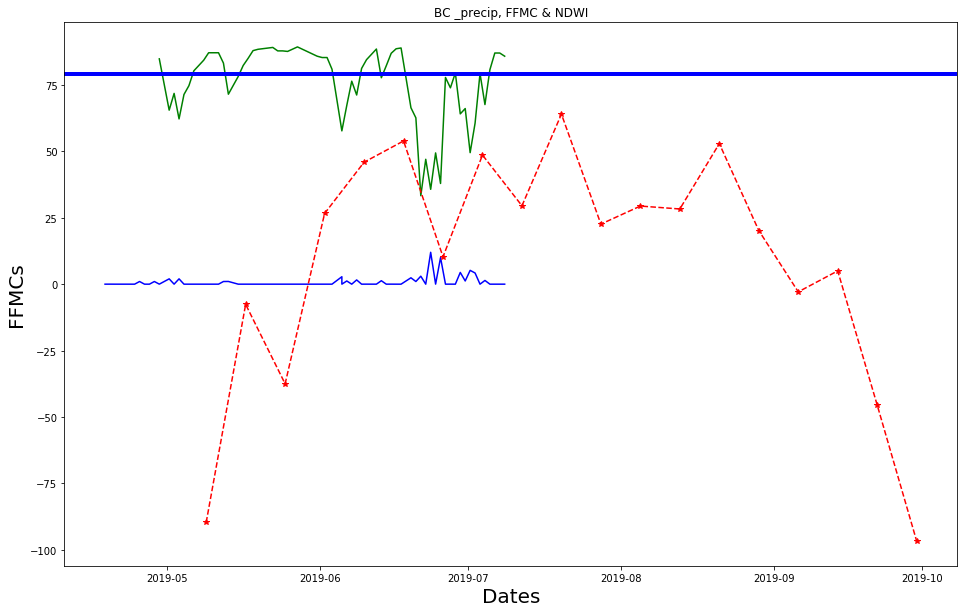

In [32]:
#Make a plot for BC ws
plt.figure(figsize=(16,10),linewidth=5)
# summer_2019.plot(figsize=(20,10), )
# plt.xlabel('DofY', fontsize=20); 
# ffmc_BC = plt.plot(summer_2019_BC['FFMC'], color='green',label='moist Ind' )
# prec_BC = plt.plot(summer_2019_BC['PRECIP'], color='blue',label='rain')
ffmc_WT = plt.plot(summer_2019_WT['FFMC'], color='green',label='moist Ind' )
prec_WT = plt.plot(summer_2019_WT['PRECIP'], color='blue',label='rain')
# # #plt.plot(summer_2019_RLA, 'ro')
plt.xlabel('Dates', fontsize=20);
plt.ylabel('FFMCs', fontsize=20);
ndwi_WT = plt.plot(ts2df_sub2/10, color='red',label='ndwis', marker='*', linestyle='dashed') 
plt.axhline(np.mean(summer_2019_BC['FFMC']),linewidth=4, color='b')
plt.title('BC _precip, FFMC & NDWI')

In [33]:
#summer_2019_RLA.tail()  
ffmc_summerMean =np.mean(summer_2019_BC['FFMC'])
ffmc_summerMean
np.max(summer_2019_BC['FFMC'])

94.1

Text(0.5, 1.0, 'RLA _precip, FFMC & NDWI')

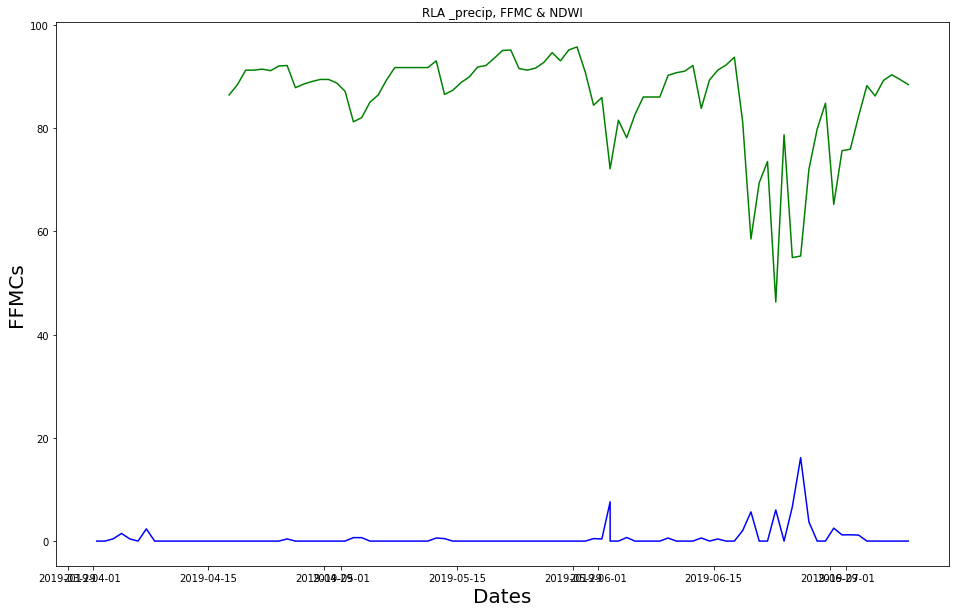

In [34]:
#Make a plot for RLA ws

plt.figure(figsize=(16,10),linewidth=5)
# summer_2019.plot(figsize=(20,10), )
# plt.xlabel('DofY', fontsize=20);   
ffmcplt = plt.plot(summer_2019_RLA['FFMC'], color='green',label='moist Ind' )
precplt = plt.plot(summer_2019_RLA['PRECIP'], color='blue',label='rain')
# # #plt.plot(summer_2019_RLA, 'ro')
plt.xlabel('Dates', fontsize=20);
plt.ylabel('FFMCs', fontsize=20);
#ndwi_trend = plt.plot(ts2df_summer/10, color='red',label='ndwis', marker='*', linestyle='dashed') 
plt.title('RLA _precip, FFMC & NDWI')

In [35]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series, DataFrame
def test_stationarity(timeseries):
    ''' We have to test if Rho – 1 is significantly different than zero or not. If the null hypothesis
    gets rejected, we’ll get a stationary time series.'''
    #Determing rolling statistics
    rolmean = timeseries.rolling(2).mean()
    rolstd = timeseries.rolling( 2).std( )
  
    # ps = ts.rolling(2).sum() #works
    #gym.rolling(5).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
    #plt.xlabel('Year', fontsize=20);
   
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='red',label='Original')
    mean = plt.plot(rolmean, color='magenta', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
#    print ('Results of Dickey-Fuller Test:')
#   dftest = adfuller(timeseries, autolag='AIC')
 #   dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
 #   for key,value in dftest[4].items():
 #       dfoutput['Critical Value (%s)'%key] = value
    #print( dfoutput)
#    print(dftest[0])

In [37]:
# test_stationarity(ts2df_summer)

### Subset by months:
#### We can make use of pandas DateTimeIndex object index.month and numpy's logical_and function to subset a time series easily by month.

#### April to August data only

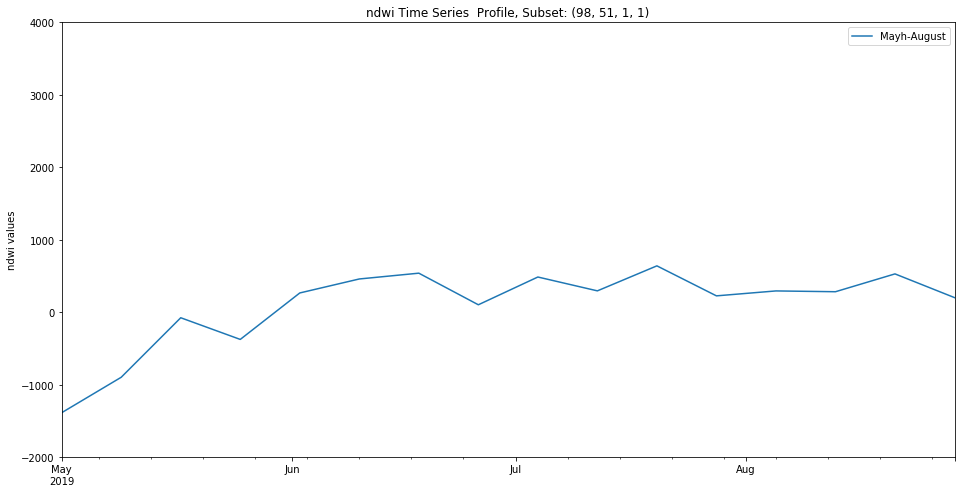

In [39]:
tsdf_summer1=ts2df[np.logical_and(ts2df.index.month>=5,ts2df.index.month<=8)]
# Plot
fig, ax = plt.subplots(figsize=(16,8))
tsdf_summer1.plot(ax=ax)
plt.title('ndwi Time Series  Profile, Subset: {}'.format(WT_dec_sub))
plt.ylabel('ndwi values')
plt.ylim(ylim)
_=plt.legend(["Mayh-August"])


In [42]:
ts2df_sub2.shape
ts2df.shape
ts2df.head(2)

,ndwis
2019-01-01,1640.0
2019-01-09,665.0


### Explore weather file 

In [49]:
summer_2019_f_p = weather_df1.loc[weather_df1.year == 2019 ,['FFMC','PRECIP']]
M_A = summer_2019_f_p['2019-05-04':'2019-07-16']
M_A.tail()


,FFMC,PRECIP
DATE,,
2019-07-06 12:00:00,90.1,0.00
2019-07-07 12:00:00,89.4,0.00
2019-07-07 12:00:00,90.1,0.00
2019-07-08 12:00:00,88.4,0.00
2019-07-08 12:00:00,88.4,0.41


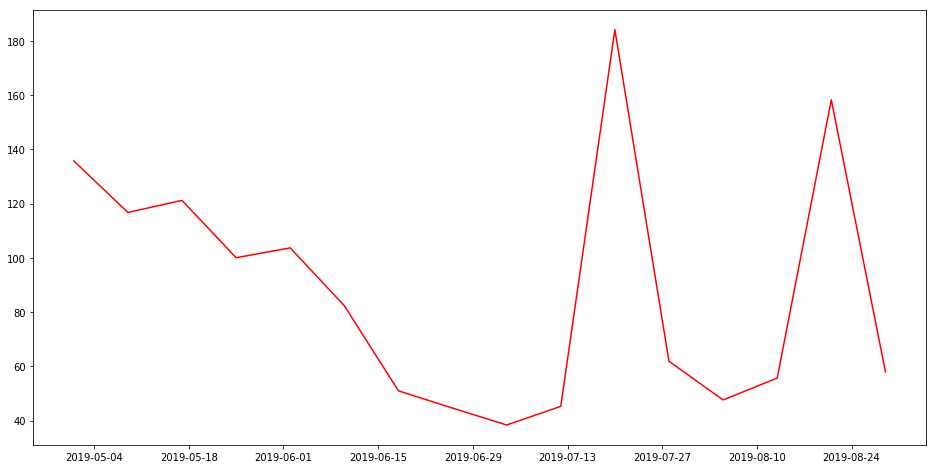

In [38]:
plt.figure(figsize=(16,8))
# ffmcplt = plt.plot(M_A['FFMC'], color='green',label='moist Ind')
# precplt = plt.plot(M_A['PRECIP'], color='blue',label='rain')

ndwi_trend = plt.plot(ts2df_summer/10, color='red',label='ndwis') 
#plt.plot(summer_2019, label= 'ffmc index')

#   orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [40]:
#weather_df.info()
#weather_df.columns = ['month', 'diet', 'gym', 'finance']
# weather_df1 =weather_df.rename(columns={"time": "dansat"})
# #weather_df.columns
# # weather_df.time.dtype
# # date = weather_df.time[1]
# # date.split(' ')[0]
# date = weather_df.time[1]
# weather_df1.dansat = pd.to_datetime(weather_df1.dansat, format='%Y-%m-%d')
# weather_df1["DofY"] = weather_df1.dansat.dt.dayofyear
# weather_df1["DofY"].head()

## create grapph
**Figure** is the top-level container in the hierarchy. It is the overall window where everything is drawn.  
**Axes** is where the plotting occurs. The axes are effectively the area that we plot data on. Each Axes has an X-Axis and a Y-Axis.

**figsize** argument, which expects a tuple of (width, height) in inches.
##### fig = plt.figure()

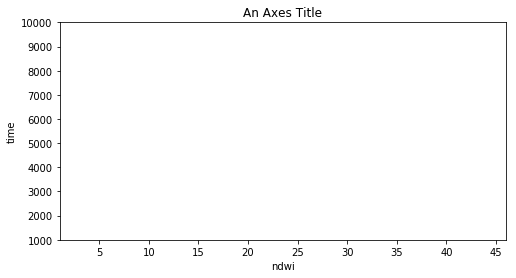

In [35]:
fig = plt.figure(figsize=(8, 4))
# Creating subplot -# Subplot with 1 row and 1 column at the index 1
ax = fig.add_subplot(111) 
# Setting axes/plot title
ax.set_title('An Axes Title')
# Setting X-axis and Y-axis limits
ax.set_xlim([1,46])
ax.set_ylim([1000, 10000])
# Setting X-axis and Y-axis labels
ax.set_ylabel('time')
ax.set_xlabel('ndwi')

plt.show()

In [44]:
#Line Plot
# In Python matplotlib, a line plot can be plotted using the plot() method. It plots Y versus X as lines and/or markers. 
# # Plot lists 'x' and 'y'
# plt.plot(x, y)

# # Plot axes labels and show the plot
# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')
# plt.show()


In [87]:
summer_2019 = weather_df1.loc[weather_df1.year == 2019 ,['FFMC',"DofY"]]
summer_2019.head(1)
# summer_2019.datum = summer_2019['time'].split(' ')[0]
# summer_2019.datum[1]



,FFMC,DofY
DATE,,
2019-04-17 12:00:00,86.4,107



### Joining data frame

##### result = pd.concat([df1, df4], axis=1, join='inner')